In [1]:
import h5py 
import numpy as np
import pandas as pd
import os


Debido a la estructura del archivo, debería leerse dos veces para poder calcular desde 
antes las dimensiones finales de los arrays a cargar. Si el archivo es masivo (>500.000 entradas)
es importante evitar concatenar arrays (numpy) o tablas (pandas) dado que ese proceso demanda RAM.

Para comenzar, la rutina que lo explora y carga todas las dimensiones:

In [14]:
def get_datainfo(filename):
    """
    Rutina para leer la información (dimensiones totales) de un archivo NDskl_ascii
    """
    d = {}
    with open(filename, "r") as f:
        ## esto puede ser un problema si el archivo es muy grande
        #lines = f.readlines()
        ## Lo cambio por una lectura progresiva:

        # 1. Cargamos ndims para crear objetos de tamaño adecuado:
        _ = f.readline()
        d['Ndims'] = int(f.readline().split()[0])

        # 2. Nos saltamos los comentarios:
        line = f.readline()
        while '#' == line[0]: line = f.readline()

        # 3. Guardamos las dimensiones espaciales:
        if "BBOX" in line.split()[0]:
            d["BBOX_min"] = [float(i) for i in line.split()[1].replace("[","").replace("]","").split(",")]
            d["BBOX_max"] = [float(i) for i in line.split()[2].replace("[","").replace("]","").split(",")]

        # 4.1. Leemos la cantidad de puntos críticos:
        while "[CRITICAL POINTS]" not in line: line = f.readline()
        d["CriticalPoints"] = int(f.readline().split()[0])

        # 4.2 Por cada punto critico sumamos su cantidad de filamentos:
        totFilsinCP = 0
        for _ in range(d["CriticalPoints"]):
            _ = f.readline()
            nFilsinCP = int(f.readline().split()[0])
            totFilsinCP += nFilsinCP
            # Nos saltamos esas líneas:
            for _ in range(nFilsinCP): _ = f.readline()
        d["CriticalPoints_NumFils"] = totFilsinCP

        # 5.1 Ahora vamos al bloque de Filamentos, cargando total: 
        while "[FILAMENTS]" not in line: line = f.readline()
        d["Filaments"] = int(f.readline().split()[0])

        # 5.2 Por cada filamento, sumamos sus puntos conectores:
        totPointsinFil = 0
        for _ in range(d["Filaments"]):
            nPointsinFil = int(f.readline().split()[-1])
            totPointsinFil += nPointsinFil
            # Nos saltamos estas líneas:
            for _ in range(nPointsinFil): _ = f.readline()
        d["Filaments_NumPoints"] = totPointsinFil
                
        # 6.1 Ahora cargaremos la sección CRITICAL POINTS DATA
        # Esta es simplemente una Tabla con dims: N_CP x NF, donde
        # NF es el número de columnas (primera info que leeremos):
        while "[CRITICAL POINTS DATA]" not in line: line = f.readline()
        d["CriticalPointsData_NF"] = int(f.readline().split()[0])
        d["CriticalPointsData_Fields"] = []
        for _ in range(d["CriticalPointsData_NF"]): 
            d["CriticalPointsData_Fields"].append(f.readline().strip())

        # 6.2 Ahora que tenemos los NF y sus nombres, nos saltamos los registros:
        for _ in range(d["CriticalPoints"]): _ = f.readline()

        # 7.1 Ahora cargaremos la sección FILAMENTS DATA
        # Esta es simplemente una Tabla con dims: N_Fil x NF, donde
        # NF es el número de columnas de esta tabla (primera info que leeremos):
        while "[FILAMENTS DATA]" not in line: line = f.readline()
        d["FilamentsData_NF"] = int(f.readline().split()[0])
        d["FilamentsData_Fields"] = []
        for _ in range(d["FilamentsData_NF"]): 
            d["FilamentsData_Fields"].append(f.readline().strip())

        # 7.2 Ahora que tenemos los NF y sus nombres, nos saltamos los registros:
        # Ojo que esta tabla tiene todos los puntos conectores de todos los filamentos, en orden:
        for _ in range(d["Filaments_NumPoints"]): _ = f.readline()
        # Done! 
    return d

Ahora, utilizando la misma anterior como punto de partida, completaremos las secciones que nos saltamos la primera vez e iremos guardando en arrays y tablas. 

Para hacer este código **modular (y extensible, ideal para compartir y facilitar su uso)** desde el inicio, agregaremos un parámetro opcional que permita seleccionar qué datos del archivo se quiere cargar, y condicionaremos cada parte a estos tags.

In [23]:
def read_NDskl_ascii(filename, fields=["[CRITICAL POINTS]","[FILAMENTS]","[CRITICAL POINTS DATA]", "[FILAMENTS DATA]"]):
    """
    Rutina para leer la información (dimensiones totales) de un archivo NDskl_ascii

    Params:
        - fields (opcional): Permite elegir qué campos del archivo se quieren cargar (todos por defecto).
                             Recibe una lista donde cada elemento almacena el nombre* del campo deseado.
                             
                             (*) El nombre debe ser idéntico a como figura en el archivo, incluyendo
                             espacios y corchetes.
    """
    # Primero obtenemos la informacion del archivo:
    ndinfo = get_datainfo(filename)

    # Armamos la estrutura del contenedor
    d = {"METADATA":ndinfo}
    d["CRITICAL_POINTS"] = {}
    d["FILAMENTS"] = {} 
    d["CRITICAL_POINTS_DATA"] = None
    d["FILAMENTS_DATA"] = None

    # Ahora leemos cada parte 
    with open(filename, "r") as f:

        Ndims = ndinfo["Ndims"]
        pos_cols = [f'Pos{d}' for d in range(Ndims)]

        ##### PRIMER BLOQUE
        # Leemos hasta el primer bloque:
        line = f.readline()
        while "[CRITICAL POINTS]" not in line: line = f.readline()
        if "[CRITICAL POINTS]" in fields:
            # Creamos un df para la info de los CP:
            cols = {'type': 'int16', 
                    **{c:'float32' for c in pos_cols},
                    'value': 'float64',
                    'pairID': 'int64',
                    'boundary': 'int16',
                    # Valores nuevos que almacenamos para encontrar sus filamentos en los arrays:
                    'nfil': 'int64',
                    'firstIndex': 'int64'}
            buf = {}
            numCP = ndinfo["CriticalPoints"]
            for c, t in cols.items(): buf[c] = np.empty(numCP, dtype=t)
            df = pd.DataFrame(buf)
            del buf
            # Y los arrays con la lista de filamentos:
            destId = np.empty(ndinfo["CriticalPoints_NumFils"], dtype='int64')
            filId = np.empty(ndinfo["CriticalPoints_NumFils"], dtype='int64')
            
            # Ahora leemos los datos
            savedfils = 0
            check = int(f.readline().split()[0])
            assert (check == ndinfo['CriticalPoints']), "Inconsistency found!: CRITICAL POINTS(1)" 
            for i in range(ndinfo["CriticalPoints"]):
                values = f.readline().split()
                # Parseamos los valores del punto:
                df.at[i, "type"] = int(values[0])
                for j, c in enumerate(pos_cols):
                    df.at[i, c] = float(values[1+j])
                df.at[i, "value"] = float(values[Ndims+1])
                df.at[i, "pairID"] = int(values[Ndims+2])
                df.at[i, "boundary"] = int(values[Ndims+3])
                # numero de filamentos del punto:
                nfil = int(f.readline().split()[0])
                df.at[i, "nfil"] = nfil
                df.at[i, "firstIndex"] = savedfils             
                # filamentos asociados al punto:
                for j in range(nfil):
                    dest, fil = [int(v) for v in f.readline().split()]
                    destId[savedfils+j] = dest
                    filId[savedfils+j] = fil
                savedfils += nfil
            assert (savedfils == ndinfo['CriticalPoints_NumFils']), "Inconsistency found! CRITICAL POINTS(2)" 
            # Almacenamos:
            d["CRITICAL_POINTS"]["CPinfo"] = df
            d["CRITICAL_POINTS"]["destID"] = destId
            d["CRITICAL_POINTS"]["filID"] = filId

        ##### SEGUNDO BLOQUE
        # Leemos segundo bloque (el while es para que avance si el anterior no se leyó)
        while "[FILAMENTS]" not in line: line = f.readline()
        if "[FILAMENTS]" in fields:
            # Creamos un df para la info de los filamentos:
            cols = {'CP1': 'int64', 
                    'CP2': 'int64',
                    'nSamp': 'int64',
                    # Valor nuevo que almacenamos para encontrar sus filamentos en los arrays:
                    'firstIndex': 'int64'}
            buf = {}
            nfil = ndinfo["Filaments"]
            for c, t in cols.items(): buf[c] = np.empty(nfil, dtype=t)
            df = pd.DataFrame(buf)
            del buf
            # Y el array con las posiciones de los sampling points:
            spoints = np.empty((ndinfo["Filaments_NumPoints"], Ndims), dtype='float32')

            # Ahora leemos los datos:
            savedpoints = 0
            check = int(f.readline().split()[0])
            assert (check == ndinfo['Filaments']), "Inconsistency found!: FILAMENTS(1)"
            for i in range(ndinfo['Filaments']):
                values = f.readline().split()
                # Parseamos los valores del punto:
                df.at[i, "CP1"] = int(values[0])
                df.at[i, "CP2"] = int(values[1])
                nSamp = int(values[2])
                df.at[i, "nSamp"] = nSamp
                df.at[i, "firstIndex"] = savedpoints
                for j in range(nSamp):
                    values = f.readline().split()
                    for k in range(Ndims):
                        spoints[savedpoints+j,k] = float(values[k])
                savedpoints += nSamp
            assert (savedpoints == ndinfo['Filaments_NumPoints']), "Inconsistency found! FILAMENTS(2)" 
            # Almacenamos:
            d["FILAMENTS"]["Finfo"] = df
            d["FILAMENTS"]["SamplingPoints"] = spoints

        ##### TERCER BLOQUE
        while "[CRITICAL POINTS DATA]" not in line: line = f.readline()
        if "[CRITICAL POINTS DATA]" in fields:
            # Creamos un df para la info completa de los CP, a partir de los nombres ya cargados:
            cols = {}
            for name in ndinfo["CriticalPointsData_Fields"]:
                if ("index" in name) or ("pair" in name):
                    cols[name] = 'int64'
                else:
                    cols[name] = 'float64'
            buf = {}
            for c, t in cols.items(): buf[c] = np.empty(ndinfo["CriticalPoints"], dtype=t)
            df = pd.DataFrame(buf)
            del buf
            
            # Ahora leemos los datos:
            check = int(f.readline().split()[0])
            assert (check == ndinfo['CriticalPointsData_NF']), "Inconsistency found!: CRITICAL POINTS DATA"
            for _ in range(ndinfo['CriticalPointsData_NF']): _ = f.readline()
            for i in range(ndinfo['CriticalPoints']):
                values = f.readline().split()
                # parseamos según caso:
                for j, cname in enumerate(ndinfo["CriticalPointsData_Fields"]):
                    if 'int64' == cols[cname]: df.at[i, cname] = int(values[j])
                    else: df.at[i, cname] = float(values[j])
            d["CRITICAL_POINTS_DATA"] = df

        ##### CUARTO BLOQUE
        while "[FILAMENTS DATA]" not in line: line = f.readline()
        if "[FILAMENTS DATA]" in fields:
            # Creamos un df para la info completa de los CP, a partir de los nombres ya cargados:
            cols = {}
            for name in ndinfo["FilamentsData_Fields"]:
                if "type" == name:
                    cols[name] = 'int16'
                else:
                    cols[name] = 'float64'
            buf = {}
            for c, t in cols.items(): buf[c] = np.empty(ndinfo["Filaments_NumPoints"], dtype=t)
            df = pd.DataFrame(buf)
            del buf
            
            # Ahora leemos los datos:
            check = int(f.readline().split()[0])
            assert (check == ndinfo['FilamentsData_NF']), "Inconsistency found!: FILAMENTS DATA"
            for _ in range(ndinfo['FilamentsData_NF']): _ = f.readline()
            for i in range(ndinfo['Filaments_NumPoints']):
            #for i in range(5):
                values = f.readline().split()
                # parseamos según caso:
                for j, cname in enumerate(ndinfo["FilamentsData_Fields"]):
                    if 'int64' == cols[cname]: df.at[i, cname] = int(values[j])
                    else: df.at[i, cname] = float(values[j])
            d["FILAMENTS_DATA"] = df
        ## Done! 
    return d

In [20]:
### Codigo para testear la rutina:

filename = "simu_2D.ND.NDnet_s3_ascii"

#dinfo = get_datainfo
d = read_NDskl_ascii(filename)

In [21]:
d.keys()

dict_keys(['METADATA', 'CRITICAL_POINTS', 'FILAMENTS', 'CRITICAL_POINTS_DATA', 'FILAMENTS_DATA'])

In [22]:
d

{'METADATA': {'Ndims': 2,
  'BBOX_min': [0.0, 0.0],
  'BBOX_max': [50000.0, 50000.0],
  'CriticalPoints': 2116,
  'CriticalPoints_NumFils': 4232,
  'Filaments': 2116,
  'Filaments_NumPoints': 71703,
  'CriticalPointsData_NF': 9,
  'CriticalPointsData_Fields': ['persistence_ratio',
   'persistence_nsigmas',
   'persistence',
   'persistence_pair',
   'parent_index',
   'parent_log_index',
   'log_field_value',
   'field_value',
   'cell'],
  'FilamentsData_NF': 5,
  'FilamentsData_Fields': ['field_value',
   'orientation',
   'cell',
   'log_field_value',
   'type']},
 'CRITICAL_POINTS': {'CPinfo':       type          Pos0          Pos1     value  pairID  boundary  nfil  \
  0        2   6153.609863   1104.589966  0.011936    1582         0     2   
  1        2    625.448975   7327.459961  0.002040    1152         0     1   
  2        2   1818.859985   7992.089844  0.010665    1579         0     3   
  3        2   2400.800049   7920.589844  0.008559    1482         0     2   
  4    

Al parecer leímos el archivo completo. Hacemos una prueba rápida con matplotlib:

In [24]:
import matplotlib.pyplot as plt

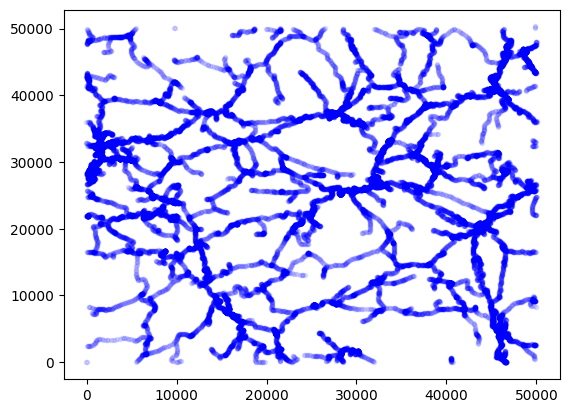

In [29]:
x = d["FILAMENTS"]["SamplingPoints"][:,0]
y = d["FILAMENTS"]["SamplingPoints"][:,1]

plt.plot(x, y, '.b', alpha=0.1) 

In [117]:
# Acceso a un único registro y columna:
d['CRITICAL_POINTS']['CPinfo'].at[1,"Pos0"]

np.float32(625.449)

Acá desarrollé la _python-magick_ de la lectura de la dimensiones en ascii ;-)  

In [28]:
# esto se lee del archivo:
a,b = "[0,0]", "[5000,5000]"

In [30]:
# transformación a lista:
[float(i) for i in b.replace("[","").replace("]","").split(",")]

[5000.0, 5000.0]

Pruebo una idea que me dio GPT para pre-allocar el DF, considerando que un número de columnas que varía según las dimensiones de los datos.

In [75]:
Ndims = 2
n_rows = 5
pos_cols = [f'Pos{d}' for d in range(Ndims)]


cols = {'type': 'int16', 
        **{c:'float32' for c in pos_cols},
        'value': 'float64',
        'pairID': 'int64',
        'boundary': 'int16'
       }
buf = {}

for c, t in cols.items(): buf[c] = np.empty(Ndims, dtype=t)


df_tmp = pd.DataFrame(buf)
del buf

print(df_tmp)


   type          Pos0  Pos1  value  pairID  boundary
0     0  1.261169e-44   0.0    0.0       0         0
1     0  0.000000e+00   0.0    0.0       0         0


In [66]:
df_tmp = pd.DataFrame({col: pd.Series([None]*n_rows, dtype=typ)
                    for col, typ in cols.items()}, columns=cols)

for col, typ in cols.items():
    print(col, typ)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

###  Código incial trabajado en la reunión
(para comparar luego. Este extraía la sección de filamentos)

In [31]:


def extract_filaments(filename):
    """
    Rutina para extraer el bloque 1 de filamentos de un archivo NDskl_ascii
    """
    d = {}
    with open(filename, "r") as f:
        with open("filaments.dat", "w") as fout:
            ## esto puede ser un problema si el archivo es muy grande
            #lines = f.readlines()
            ## Lo cambio por datosuna lectura progresiva:

            # 1. Cargamos ndims para crear objetos de tamaño adecuado:
            _ = f.readline()
            d['Ndims'] = int(f.readline().spli()[0])

            # 2. Nos saltamos los comentarios:
            line = f.readline()
            if '#' == line[0]: line = f.readline()

            # 3. Guardamos las dimensiones espaciales:
            if "BBOX" in line.split()[0]:
                
            
            # Nos saltamos todas las líneas hasta encontrar 
            # el tag del bloque que no interesa:
            while True:
                df = {}
                line = f.readline()
                if "[FILAMENTS]" in line:
                    df["findex"] = i
                    df["nFilaments"] = int(f.readline().spli()[0])
                    break
                    

                    
            currentfil = findex+1
            totallines = 0
            print(f"{currentfil} {totallines}")
            for i in range(2):
                totallines += lines[currentfil].split()[2]+1
                currentfil += lines[currentfil].split()[2]+1

            for i in range(totallines):
                fout.write(lines[i+findex])        

IndentationError: expected an indented block after 'if' statement on line 21 (53757026.py, line 26)

In [16]:
extract_filaments(filename)

8471 0


IndexError: list index out of range